In [2]:
import pandas as pd
import yaml
import pandas as pd

with open("books.yaml", "r") as f:
    books_raw = yaml.safe_load(f)

books = pd.DataFrame([{k.lstrip(":"): v for k, v in d.items()} for d in books_raw])
users = pd.read_csv("users.csv")
orders = pd.read_parquet("orders.parquet")

In [4]:
books.head()

,id,title,author,genre,publisher,year
0,21778,Call of Duty: World at War,Elmer Parker,Mythopoeia,Orion Books,2003
1,21374,WarioWare: Touched!,Ms. Kami Prosacco,Mythology,St. Martin's Press,1951
2,21457,Titanic: Music from the Motion Picture,Zoila Christiansen,Historical fiction,"Farrar, Straus & Giroux",2009
3,21881,Flashdance: Original Soundtrack from the Motio...,"Joseph Raynor, Ja Ankunding II",Metafiction,Pen and Sword Books,2024
4,21446,Riot!,Louanne Cruickshank,Mystery,Bellevue Literary Press,1987


In [6]:
users.head()

,id,name,address,phone,email
0,47856,Tammie Mayer,"Apt. 371 1875 Gusikowski Stravenue, Moenland, ...",163.212.2656,maire.larson@runolfsdottir-mclaughlin.example
1,49394,Evia Yost,"22610 Mildred Green, Pagacbury, AZ 19393-2103",778.926.6707,byron@johnston.test
2,48386,Margery Gorczany,"Apt. 884 349 Renner Lane, East Darren, NC 30837",992 375 5021,cletus@baumbach.test
3,49547,Edris Kshlerin,"Suite 498 24711 Bechtelar Extensions, Ryanvill...",747.537.2209,leonore@gleason.test
4,50512,Meghan Thiel,"125 Rodger Drive, Rogahnborough, VT 96988-4596",(631) 765-7676,cristine@bayer.test


In [8]:
orders.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping
0,80941,47864,21550,1,67.0 €,2025-01-11 09:50:11 PM,
1,81245,47864,22052,2,EUR26.99,2024-03-27T07:46:55.055,
2,78477,48918,21367,1,30 $,"11:17:51 PM, 29-JUN-2025",
3,86303,48092,21724,1,18 $,09:29;11/06/24,None
4,81990,48418,21441,1,USD 24.99,2024-09-16;03:05:39 pm,None


In [11]:
books_copy = books.copy()
users_copy = users.copy()
orders_copy = orders.copy()

In [13]:
import pandas as pd
import yaml
import pyarrow.parquet as pq
import re
import numpy as np
from datetime import datetime

## Managing data and cleaning
## Users

In [16]:
for col in ["name", "address", "phone", "email"]:
    if col in users.columns:
        users[col] = users[col].astype(str).str.strip()
        
def normalize_phone(phone):
    if pd.isna(phone):
        return np.nan
    
    digits = re.sub(r"\D", "", str(phone))

    if len(digits) != 10:
        return np.nan  

    return f"{digits[0:3]}-{digits[3:6]}-{digits[6:10]}"

users["phone_clean"] = users["phone"].apply(normalize_phone)

users.head()

,id,name,address,phone,email,phone_clean
0,47856,Tammie Mayer,"Apt. 371 1875 Gusikowski Stravenue, Moenland, ...",163.212.2656,maire.larson@runolfsdottir-mclaughlin.example,163-212-2656
1,49394,Evia Yost,"22610 Mildred Green, Pagacbury, AZ 19393-2103",778.926.6707,byron@johnston.test,778-926-6707
2,48386,Margery Gorczany,"Apt. 884 349 Renner Lane, East Darren, NC 30837",992 375 5021,cletus@baumbach.test,992-375-5021
3,49547,Edris Kshlerin,"Suite 498 24711 Bechtelar Extensions, Ryanvill...",747.537.2209,leonore@gleason.test,747-537-2209
4,50512,Meghan Thiel,"125 Rodger Drive, Rogahnborough, VT 96988-4596",(631) 765-7676,cristine@bayer.test,631-765-7676


## Books

In [20]:
def split_authors(s):
    s = re.sub(r"[;&|]", ",", s)
    parts = [p.strip() for p in s.split(",") if p.strip() != ""]
    return parts

books_copy["author_list"] = books_copy["author"].apply(split_authors)
books_copy["author_set"] = books_copy["author_list"].apply(lambda x: frozenset(x))

books_copy.head()

,id,title,author,genre,publisher,year,author_list,author_set
0,21778,Call of Duty: World at War,Elmer Parker,Mythopoeia,Orion Books,2003,[Elmer Parker],(Elmer Parker)
1,21374,WarioWare: Touched!,Ms. Kami Prosacco,Mythology,St. Martin's Press,1951,[Ms. Kami Prosacco],(Ms. Kami Prosacco)
2,21457,Titanic: Music from the Motion Picture,Zoila Christiansen,Historical fiction,"Farrar, Straus & Giroux",2009,[Zoila Christiansen],(Zoila Christiansen)
3,21881,Flashdance: Original Soundtrack from the Motio...,"Joseph Raynor, Ja Ankunding II",Metafiction,Pen and Sword Books,2024,"[Joseph Raynor, Ja Ankunding II]","(Joseph Raynor, Ja Ankunding II)"
4,21446,Riot!,Louanne Cruickshank,Mystery,Bellevue Literary Press,1987,[Louanne Cruickshank],(Louanne Cruickshank)


## Orders

In [24]:
import re
import pandas as pd
from dateutil import parser

def parse_timestamp(s):
    if pd.isna(s):
        return pd.NaT
    
    s = str(s).strip()
    
    s = s.replace("A.M.", "AM").replace("P.M.", "PM")
    s = s.replace("A.M", "AM").replace("P.M", "PM")
    s = s.replace("a.m.", "AM").replace("p.m.", "PM")
    s = s.replace("a.m", "AM").replace("p.m", "PM")
    s = s.replace("am", "AM").replace("pm", "PM")
    s = s.replace(";", " ").replace(",", " ")
    s = re.sub(r"\s+", " ", s)
    
    try:
        dt = parser.parse(s, dayfirst=False, fuzzy=True)
        return dt
    except Exception:
        return pd.NaT

In [26]:
orders_copy["timestamp_parsed"] = orders_copy["timestamp"].apply(parse_timestamp)
orders_copy["date"] = orders_copy["timestamp_parsed"].dt.date

orders_copy.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date
0,80941,47864,21550,1,67.0 €,2025-01-11 09:50:11 PM,,2025-01-11 21:50:11.000,2025-01-11
1,81245,47864,22052,2,EUR26.99,2024-03-27T07:46:55.055,,2024-03-27 07:46:55.055,2024-03-27
2,78477,48918,21367,1,30 $,"11:17:51 PM, 29-JUN-2025",,2025-06-29 23:17:51.000,2025-06-29
3,86303,48092,21724,1,18 $,09:29;11/06/24,None,2024-11-06 09:29:00.000,2024-11-06
4,81990,48418,21441,1,USD 24.99,2024-09-16;03:05:39 pm,None,2024-09-16 15:05:39.000,2024-09-16


In [28]:
import re
import numpy as np
import pandas as pd

def parse_price(p):
    if pd.isna(p):
        return np.nan

    s = str(p).strip().replace(" ", "") 

    s = s.replace("¢", ".")

    if ("$" in s or "€" in s) and "." not in s:
        parts = re.split(r"[$€]", s)
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            value = float(parts[0] + "." + parts[1])
            return value if "$" in s else value * 1.2

    nums = re.findall(r"\d+(?:\.\d+)?", s)
    if not nums:
        return np.nan

    value = nums[0]

    if value.endswith("."):
        value = value[:-1]

    if value == "":
        return np.nan

    value = float(value)

    if "$" in s or "USD" in s.upper():
        return value

    if "€" in s or "EUR" in s.upper():
        return value * 1.2

    return np.nan

In [30]:
orders_copy["unit_price_usd"] = orders_copy["unit_price"].apply(parse_price)
orders_copy["paid_price"] = orders_copy["unit_price_usd"] * orders_copy["quantity"]

orders_copy.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date,unit_price_usd,paid_price
0,80941,47864,21550,1,67.0 €,2025-01-11 09:50:11 PM,,2025-01-11 21:50:11.000,2025-01-11,80.400,80.400
1,81245,47864,22052,2,EUR26.99,2024-03-27T07:46:55.055,,2024-03-27 07:46:55.055,2024-03-27,32.388,64.776
2,78477,48918,21367,1,30 $,"11:17:51 PM, 29-JUN-2025",,2025-06-29 23:17:51.000,2025-06-29,30.000,30.000
3,86303,48092,21724,1,18 $,09:29;11/06/24,None,2024-11-06 09:29:00.000,2024-11-06,18.000,18.000
4,81990,48418,21441,1,USD 24.99,2024-09-16;03:05:39 pm,None,2024-09-16 15:05:39.000,2024-09-16,24.990,24.990


In [34]:
users_clean = users.copy()
users_clean = users_clean.rename(columns={"id": "user_id"})

books_clean = books_copy.copy()
books_clean = books_clean.rename(columns={"id": "book_id"})

orders_clean = orders_copy.copy()

orders_users = orders_clean.merge(
    users_clean,
    on="user_id",
    how="left",
    suffixes=("", "_user")
)

full = orders_users.merge(
    books_clean,
    on="book_id",
    how="left",
    suffixes=("", "_book")
)

full.head()

,id,user_id,book_id,quantity,unit_price,timestamp,shipping,timestamp_parsed,date,unit_price_usd,...,phone,email,phone_clean,title,author,genre,publisher,year,author_list,author_set
0,80941,47864,21550,1,67.0 €,2025-01-11 09:50:11 PM,,2025-01-11 21:50:11.000,2025-01-11,80.400,...,891-409-9431,fausto_terry@reinger.example,891-409-9431,All the King's Men,Shanelle Upton,Mystery,Unfinished Monument Press,2010,[Shanelle Upton],(Shanelle Upton)
1,81245,47864,22052,2,EUR26.99,2024-03-27T07:46:55.055,,2024-03-27 07:46:55.055,2024-03-27,32.388,...,891-409-9431,fausto_terry@reinger.example,891-409-9431,Cidade de Deus,Johnny Russel,Reference book,Gay Men's Press,1979,[Johnny Russel],(Johnny Russel)
2,78477,48918,21367,1,30 $,"11:17:51 PM, 29-JUN-2025",,2025-06-29 23:17:51.000,2025-06-29,30.000,...,553.378.3093,loyce@gottlieb-durgan.example,553-378-3093,Platoon,Ms. Kami Prosacco,Tall tale,Black Dog Publishing,1991,[Ms. Kami Prosacco],(Ms. Kami Prosacco)
3,86303,48092,21724,1,18 $,09:29;11/06/24,None,2024-11-06 09:29:00.000,2024-11-06,18.000,...,(199) 483-6925,howard@jakubowski.test,199-483-6925,The Doors of Perception,Amos Romaguera Jr.,Horror,Etruscan Press,2012,[Amos Romaguera Jr.],(Amos Romaguera Jr.)
4,81990,48418,21441,1,USD 24.99,2024-09-16;03:05:39 pm,None,2024-09-16 15:05:39.000,2024-09-16,24.990,...,648 168 5886,vicki_mertz@abshire.test,648-168-5886,The Godfather,"Edmundo Oberbrunner, Bernard Bayer, Amb. Elia ...",Essay,George Routledge & Sons,1937,"[Edmundo Oberbrunner, Bernard Bayer, Amb. Elia...","(Bernard Bayer, Edmundo Oberbrunner, Amb. Elia..."


In [36]:
full.to_excel("full3.xlsx", index=False)
users.to_excel("users3.xlsx", index=False)

### Let's try to find the needed info based on the tasks

In [38]:
users.columns

Index(['id', 'name', 'address', 'phone', 'email', 'phone_clean'], dtype='object')

In [41]:
daily_revenue = (
    full.dropna(subset=["date"]) 
        .groupby("date", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "daily_revenue"})
        .sort_values("date")
)

top5_days = daily_revenue.sort_values("daily_revenue", ascending=False).head(5)

print("Top 5 days by revenue using the format 'YYYY-MM-dd' (DATA3):")
print(top5_days)
print()
#####################################################################################

# union-find
parent = {}

def find(x):
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

for uid in users["id"]:
    parent[uid] = uid

fields = ["email", "phone_clean", "name", "address"]

for col in fields:
    groups = (
        users.dropna(subset=[col])
             .groupby(col)["id"]
             .apply(list)
    )
    for _, uids in groups.items():
        if len(uids) > 1:
            base = uids[0]
            for other in uids[1:]:
                union(base, other)

clusters = {}
for uid in users["id"]:
    root = find(uid)
    clusters.setdefault(root, []).append(uid)

num_real_users = len(clusters)
print("Number of unique users (real, reconciled) (DATA3):", num_real_users)
print()

#####################################################################################

num_author_sets = books_copy["author_set"].nunique()
print("Number of unique sets of authors (DATA3):", num_author_sets)
print()

#####################################################################################

author_popularity = (
    full.dropna(subset=["author_set"])
        .groupby("author_set")["quantity"]
        .sum()
        .sort_values(ascending=False)
)

top_author_set = author_popularity.index[0]
top_author_qty = author_popularity.iloc[0]

print("The most popular author(s) (DATA3):", list(top_author_set))
print("Number of sold books:", top_author_qty)
print()

#####################################################################################

user_to_real = {uid: find(uid) for uid in users["id"]}

full["real_user"] = full["user_id"].map(user_to_real)

spending = (
    full.groupby("real_user")["paid_price"]
        .sum()
        .sort_values(ascending=False)
)

best_real_user = spending.index[0]
best_buyer_aliases = clusters[best_real_user]

print("Best buyer (with aliases) as an array of ids ([id1, id2, ...]) (DATA3):", best_buyer_aliases)
print()

Top 5 days by revenue using the format 'YYYY-MM-dd' (DATA3):
           date  daily_revenue
295  2024-11-16       3688.192
371  2025-01-31       3341.980
274  2024-10-26       3127.920
291  2024-11-12       3034.540
280  2024-11-01       2954.020

Number of unique users (real, reconciled) (DATA3): 3111

Number of unique sets of authors (DATA3): 268

The most popular author(s) (DATA3): ['Coy Streich', 'Keeley Hand', 'Lela Emard']
Number of sold books: 159

Best buyer (with aliases) as an array of ids ([id1, id2, ...]) (DATA3): [50940, 49280, 48781, 50193, 48061, 48306, 47706, 49345, 48328, 49389, 49541, 47945, 50411, 49948, 49035, 50554, 49233, 49930, 50216, 50037, 48675, 48301, 50664, 49594, 48322, 50406, 49815, 50902, 50878, 47701, 51025, 50044, 48307, 47923, 47813, 47735, 50977, 50876, 49991, 48723, 50118, 49468, 48371, 50080, 47750, 50621, 50344, 48294, 49962, 48202, 48853, 48295, 49941, 50936, 50147, 48198, 51058, 49613, 49938, 50103, 50789, 50306, 48761, 50234, 50440, 49128, 47891

In [43]:
summary_data2 = pd.DataFrame({
    "metric": [
        "num_real_users",
        "num_author_sets",
        "most_popular_authors",
        "most_popular_authors_sold",
        "best_buyer_aliases"
    ],
    "value": [
        num_real_users,
        num_author_sets,
        ", ".join(list(top_author_set)),
        top_author_qty,
        str(best_buyer_aliases)
    ]
})

summary_data2.to_excel("DATA3_summary_metrics.xlsx", index=False)

In [64]:
alias_spending = (
    full[full["user_id"].isin(best_buyer_aliases)]
        .groupby("user_id", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "alias_spent"})
)

best_buyer_table = (
    alias_spending
        .merge(users, left_on="user_id", right_on="id", how="left")
        .sort_values("alias_spent", ascending=False)
)

best_buyer_table.to_excel("DATA3_best_buyer_aliases.xlsx", index=False)

In [60]:
top_author_sets = (
    full.dropna(subset=["author_set"])
        .groupby("author_set", as_index=False)["quantity"]
        .sum()
        .rename(columns={"quantity": "sold_books"})
        .sort_values("sold_books", ascending=False)
)

top_author_sets10 = top_author_sets.copy()
top_author_sets10["authors"] = top_author_sets10["author_set"].apply(lambda s: ", ".join(sorted(list(s))))
top_author_sets10 = top_author_sets10[["authors", "sold_books"]]

top_author_sets10.to_excel("DATA3_top_author_sets10.xlsx", index=False)

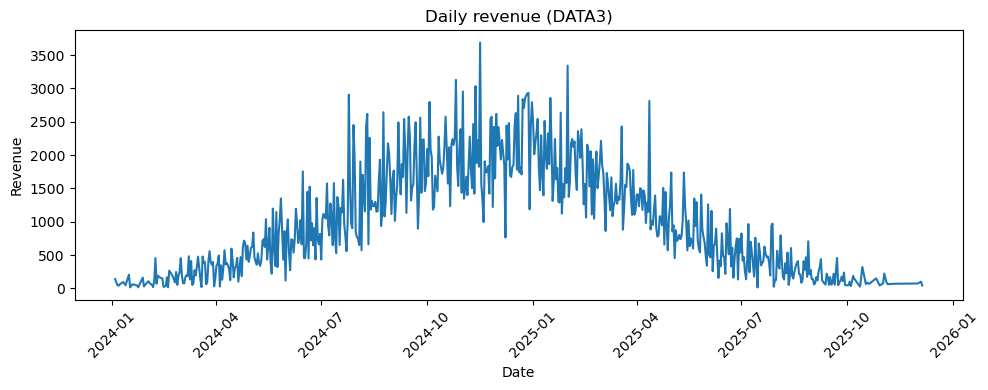

In [45]:
import matplotlib.pyplot as plt

daily_revenue = (
    full.dropna(subset=["date"])              
        .groupby("date", as_index=False)["paid_price"]
        .sum()
        .rename(columns={"paid_price": "daily_revenue"})
        .sort_values("date")
)

plt.figure(figsize=(10, 4))
plt.plot(daily_revenue["date"], daily_revenue["daily_revenue"])
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Daily revenue (DATA3)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()